In [1]:
import os

import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2

import matplotlib.pyplot as plt
import ipympl

from typing import Tuple

# Standard CV2 circle detection (Hough Circle)

In [ ]:
img = cv2.cvtColor(cv2.imread(os.path.join("testing_data", "image.png")), cv2.COLOR_BGR2GRAY)
output = img.copy()

circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=40, maxRadius=60)

if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        cv2.circle(output, (x, y), r, (0, 255, 0), 4)
        cv2.rectangle(output, (x-5, y-5), (x+5, y+5), (0, 128, 255), -1)
    
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].imshow(img, cmap='gray')
ax[1].imshow(output, cmap='gray')

# Helper functions for plotting

In [2]:
def to_three_channels(_label: np.ndarray) -> np.ndarray:
    return np.squeeze(np.stack((_label, _label, _label), 2))

def show_sample(_image: np.ndarray, _label: np.ndarray) -> plt.Figure:
    fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
    ax[0].imshow(_image, cmap="gray")
    ax[0].set_title("Raw Data")
    ax[1].imshow(to_three_channels(_label), cmap="gray")
    ax[1].set_title("Labelled Data")
    fig.tight_layout()
    return fig
    
def show_batch(_images: np.ndarray, _labels: np.ndarray):
    return show_sample(_images[0, :, :, :], _labels[0, :, :, :])
    
def show_result(_images: np.ndarray, _labels: np.ndarray, _preds: np.ndarray) -> plt.Figure:
    fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(10, 7))
    ax[0].imshow(_images[0, :, :, :], cmap="gray")
    ax[0].set_title("Raw Data")
    ax[1].imshow(to_three_channels(_labels[0, :, :, :]), cmap="gray")
    ax[1].set_title("Labelled Data")
    ax[2].imshow(to_three_channels(_preds[0, :, :, :]), cmap="gray")
    ax[2].set_title("Neural Network")
    fig.tight_layout()
    return fig

# Test data

In [3]:
def add_square(_img: np.ndarray, center: tuple, width: int):
    start_point = (center[0] - width, center[1] - width)
    end_point   = (center[0] + width, center[1] + width)
    cv2.rectangle(_img, start_point, end_point, random_color(), cv2.FILLED)

def random_color():
    return np.random.rand(3)

def create_data_sample(num_shapes: int, height: int, width: int) -> Tuple[np.ndarray, np.ndarray]:
    _img = np.zeros((height, width, 3))
    _label = np.zeros((height, width, 1))
    for _ in range(num_shapes):
        x = int(np.random.rand() * width)
        y = int(np.random.rand() * height)
        if np.random.rand() > 0.5:
            cv2.circle(_img, (x,y), int(np.ceil(width * 0.15)), random_color(), cv2.FILLED)
            cv2.circle(_label, (x,y), int(np.ceil(width * 0.15)), (1, 1, 1))
        else: 
            add_square(_img, (x,y), int(np.ceil(width * 0.1 * 0.7)))
    return _img, _label

def test_batch(num_shapes: int, height: int, width: int) -> np.ndarray:
    _img, _label = create_data_sample(num_shapes, height, width)
    return np.expand_dims(_img, 0), np.expand_dims(_label, 0)

### Sample test data

(128, 128, 3) (128, 128, 1)


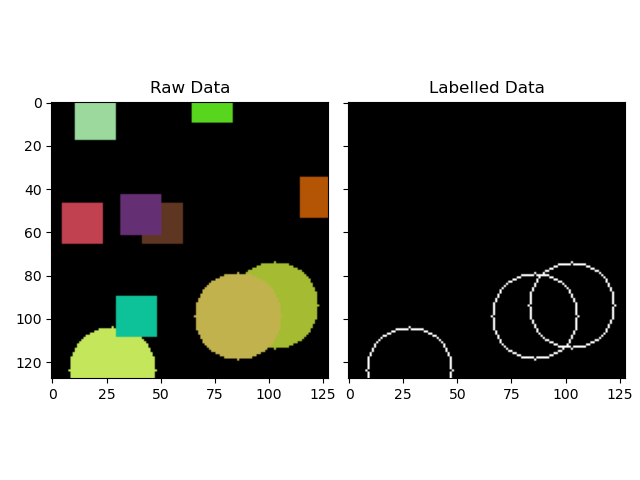

In [4]:
%matplotlib widget
img_shape = (128, 128, 3)
img, label = create_data_sample(10, img_shape[0], img_shape[1])

show_sample(img, label)
print(img.shape, label.shape)

### Batch test data

(1000, 128, 128, 3) (1000, 128, 128, 1)


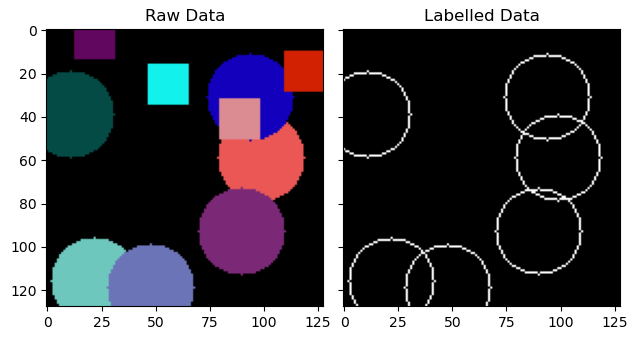

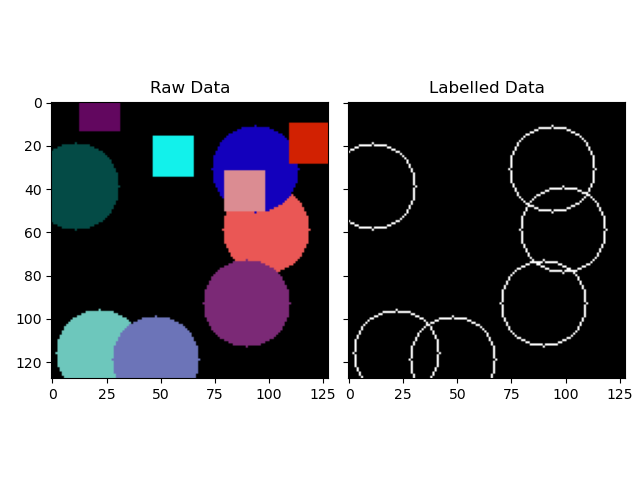

In [5]:
img_batch = []
label_batch = []

for idx in range(1000):
    img, label  = create_data_sample(10, img_shape[0], img_shape[1])
    img_batch.append(img)
    label_batch.append(label)
    
img_batch = np.array(img_batch)
label_batch = np.array(label_batch)

print(img_batch.shape, label_batch.shape)
show_batch(img_batch, label_batch)

# Real data

In [ ]:
def load_image(image_path: str, circle_label: tuple, overlay: bool = False) -> Tuple[np.ndarray, np.ndarray]:
    raw = cv2.imread(image_path)
    _, image = cv2.threshold(cv2.bitwise_not(raw), 80, 255, cv2.THRESH_BINARY)
    image = image.astype("float32") / 255
    
    label = np.zeros((image.shape[0], image.shape[1], 1), dtype="float32")
    cv2.circle(label, (circle_label[0], circle_label[1]), int(np.ceil(label.shape[1] * circle_label[2])), (1, 1, 1))
    if overlay:
        cv2.circle(image, (circle_label[0], circle_label[1]), int(np.ceil(label.shape[1] * circle[2])), (1, 1, 1))
        
    return raw, image, label

def load_images_from_folder(folder: str, circle_labels: list) -> Tuple[np.ndarray, np.ndarray]:
    image_files = os.listdir(folder)
    num_images = len(image_files)
    num_labels = len(circle_labels)
    
    if num_images != num_labels:
        raise ValueError(f"Invalid number of labels ({num_labels}) for images ({num_images})")
        
    images = []
    labels = []
    for idx, image in enumerate(image_files):
        _, image, label = load_image(os.path.join(folder, image), circle_labels[idx])
        images.append(image)
        labels.append(label)
        
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

def load_test_image(image_path: str, circle_label: tuple) -> Tuple[np.ndarray, np.ndarray]:
    image, label = load_image(image_path, circle_label)
    return np.expand_dims(image, 0), np.expand_dims(label, 0)

### Sample real data

In [ ]:
raw, img, label = load_image(os.path.join("training_data", "image.png"), (295, 175, 0.08), overlay=False)

img_shape = img.shape

fig, ax = plt.subplots()
ax.imshow(raw)
fig.savefig(os.path.join("results", "real_data_raw.png"), dpi=300, bbox_inches='tight')

fig = show_sample(img, label)
fig.savefig(os.path.join("results", "real_data_processed.png"), dpi=300, bbox_inches='tight')

### Batch real data

In [ ]:
img_batch, label_batch = load_images_from_folder("training_data", [(295, 175, 0.08)])

print(img_batch.shape, label_batch.shape)
show_batch(img_batch, label_batch)

# Convolutional Neural Network (CNN)

## 3 layer network

In [6]:
inputs = keras.Input(shape=img.shape)
conv1 = keras.layers.Conv2D(16, 5, padding='same', activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=None)(inputs)
conv1 = keras.layers.BatchNormalization(momentum=0.99)(conv1)
conv2 = keras.layers.Conv2D(32, 5, padding='same', activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=None)(conv1)
conv2 = keras.layers.BatchNormalization(momentum=0.99)(conv2)
outputs = keras.layers.Conv2D(1, 5, padding='same', activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=None)(conv2)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      1216      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      12832     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 1)       801   

## Define a reduced mean square loss function

In [7]:
def loss_function(y_true, y_pred):
    squared_diff = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_diff)

## Compile CNN optimizer

In [8]:
opt = keras.optimizers.Adam(learning_rate=5e-4)
model.compile(optimizer=opt,loss=loss_function)

In [9]:
model.fit(img_batch, label_batch, batch_size=10, epochs=10)

2022-04-25 14:40:19.166793: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10
100/100 [==============================] - 21s 206ms/step - loss: 0.0550
Epoch 2/10
100/100 [==============================] - 20s 202ms/step - loss: 0.0188
Epoch 3/10
100/100 [==============================] - 23s 234ms/step - loss: 0.0156
Epoch 4/10
100/100 [==============================] - 23s 228ms/step - loss: 0.0139
Epoch 5/10
100/100 [==============================] - 21s 214ms/step - loss: 0.0129
Epoch 6/10
100/100 [==============================] - 24s 234ms/step - loss: 0.0123
Epoch 7/10
100/100 [==============================] - 21s 213ms/step - loss: 0.0118
Epoch 8/10
100/100 [==============================] - 22s 216ms/step - loss: 0.0115
Epoch 9/10
100/100 [==============================] - 24s 237ms/step - loss: 0.0112
Epoch 10/10
100/100 [==============================] - 25s 247ms/step - loss: 0.0110


# Visualize results

### Test data results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


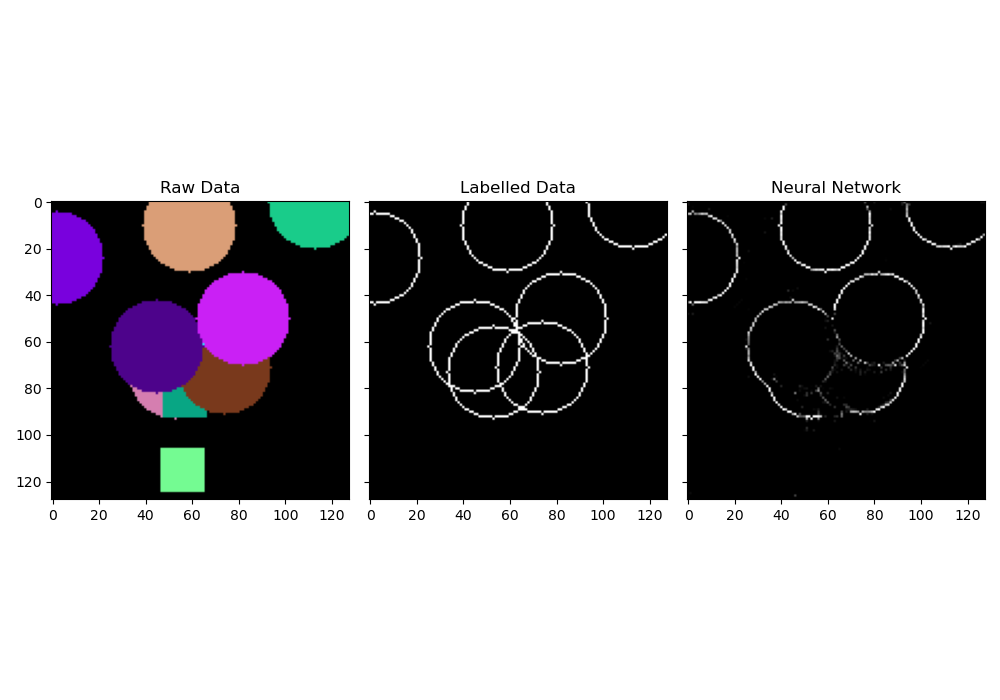

In [11]:
img, label = test_batch(10, img_shape[0], img_shape[1])
pred = model.predict(img)

fig = show_result(img, label, pred)
fig.savefig(os.path.join("results", "test_data_result.png"), dpi=300, bbox_inches='tight')

### Real data results

In [ ]:
img, label = load_test_image(os.path.join("testing_data", "image.png"), (295, 175, 0.08))
pred = model.predict(img)

show_result(img, label, pred)
fig.savefig(os.path.join("results", "real_data_result.png"), dpi=300, bbox_inches='tight')

# Save model if training successful

In [12]:
model.save('detection_model')

2022-04-25 14:49:48.979477: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: detection_model/assets
